# 3.3 LangGraph에서 도구(tool) 활용 방법

In [1]:
# from dotenv import load_dotenv

# load_dotenv(dotenv_path="../.env")

In [1]:
from langchain_ollama import ChatOllama
# from langchain_openai import ChatOpenAI

llm = ChatOllama(model="llama3.1")
# llm = ChatOllama(model="qwen2.5")
# llm = ChatOpenAI(model="gpt-4o-mini")

c:\Users\a1ljm\Desktop\ANSWER_25\inflearn-langgraph-agent\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """숫자 a와 b를 더합니다."""
    return a+b

@tool
def mul(a: int, b: int) -> int:
    """숫자 a와 b를 곱합니다."""
    return a*b

In [3]:
from langgraph.prebuilt import ToolNode

tools = [add, mul]
llm_with_tools = llm.bind_tools(tools=tools)
tool_node = ToolNode(tools=tools)

In [4]:
mul.invoke({"a": 3, "b": 5})

15

In [5]:
query = "3 곱하기 5는?"
ai_message = llm_with_tools.invoke(query)
ai_message.tool_calls

[{'name': 'mul',
  'args': {'a': 3, 'b': 5},
  'id': '101435f2-39b9-43ab-af74-6adeae9ca85b',
  'type': 'tool_call'}]

에러 해결 안됨. 일단 넘어가자 (251221)  
https://www.inflearn.com/community/questions/1717823/3-3-%EA%B0%95%EC%9D%98-%EC%97%90%EB%9F%AC-%EC%A7%88%EB%AC%B8?srsltid=AfmBOopvvRKqWZ0UDYpKlxQGqbzanir4S7sK-f41uQsEqKXK7BTGckRw

In [ ]:
# response = tool_node.invoke({"messages": [ai_message]})
# response = tool_node.invoke({"messages": [ai_message]}, config={"tools": tools})
# response

In [7]:
from langgraph.graph import StateGraph, MessagesState

workflow = StateGraph(MessagesState)

def agent(state: MessagesState) -> MessagesState:
    """
    'agent' 함수는 주어진 상태에서 메시지를 가져와, LLM과 도구를 사용하여 응답 메시지를 생성합니다.
    Args:
        state (MessagesState): 메시지 상태를 포함하는 state
    Returns:
        MessagesState: 응답 메시지를 포함하는 새로운 state
    """
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

In [9]:
from typing import Literal

def should_contine(state: MessagesState) -> Literal["tools", "end"]:
    """
    주어진 메시지 상태를 기반으로 agent가 계속 진행할지 여부를 결정합니다.
    Args:
        state (MessagesState): 'state'를 포함하는 객체
    Returns:
        Literal["tools", "end"]: 도구를 사용해야 하면 "tools"를 반환하고,
        답변할 준비가 되었다면 "end"를 반환해서 프로세스를 종료합니다.
    """
    messages = state["messages"]
    if messages[-1].tool_calls:
        return "tools"
    return "end"

In [10]:
from langgraph.graph import START, END

workflow.add_node("agent", agent)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_contine, {
    "tools": "tools",
    "end": END,
})
workflow.add_edge("tools", "agent")

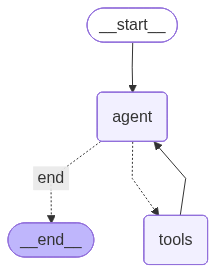

In [11]:
from IPython.display import display, Image

graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
from langchain_core.messages import HumanMessage

query = "3과 5를 더하고, 그 결과에 8을 곱하면?"
responses = graph.stream(input={"messages": HumanMessage(query)}, stream_mode="values")
for response in responses:
    response["messages"][-1].pretty_print()

================================ Human Message =================================

3과 5를 더하고, 그 결과에 8을 곱하면?
================================== Ai Message ==================================
Tool Calls:
  mul (e8410c9b-d673-4ca9-8bb1-5ed0865dea7d)
 Call ID: e8410c9b-d673-4ca9-8bb1-5ed0865dea7d
  Args:
    a: add
    b: 8
================================= Tool Message =================================
Name: mul

Error invoking tool 'mul' with kwargs {'a': 'add', 'b': 8} with error:
 a: Input should be a valid integer, unable to parse string as an integer
 Please fix the error and try again.
================================== Ai Message ==================================

3과 5를 더하면 8이 됩니다.
그 결과에 8을 곱하면 64가 됩니다.

{"name": "mul", "parameters": {"a":3,"b":5}}
